# Covid restrictions.

**Setting up the environment**
Initialization of the Ontology editor in Jupyter Notebook

In [1]:
from cognipy.ontology import Ontology
from cognipy.ontology import CQL
from cognipy.ontology import ABoxBatch
from cognipy.ontology import encode_string_for_graph_label
from cognipy.edit import CnlEditBox
from cognipy.edit import CnlQueryForConcept

import random
import textwrap
import numpy as np
import pandas as pd
import pickle
import datetime

def graph_attribute_formatter(val):
    if isinstance(val,list) or isinstance(val,set):
        return " | ".join(list(map(lambda i:encode_string_for_graph_label(graph_attribute_formatter(i)),val)))
    elif isinstance(val,dict):
        return " | ".join(list(map(lambda i:i[0]+" : "+encode_string_for_graph_label(graph_attribute_formatter(i[1])),val.items())))
    else:
        return encode_string_for_graph_label(textwrap.fill(str(val),40))

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity

def Qstr(a):
    return "Q('"+str(a)+"')"
Q.__repr__=Qstr    


Lets setup the fist ontology editor for the general knowledge. The editor allows you to enter the knowledge in text format, and support you with the prdictive editor.

In [2]:
parts_editors={}
parts_editors['01']=CnlEditBox('countries.encnl')
parts_editors['02']=CnlEditBox('border_cross_quarantine.encnl')
parts_editors['03']=CnlEditBox('face_cover.encnl')
parts_editors['04']=CnlEditBox('lockdown.encnl')
parts_editors['05']=CnlEditBox('mass_coronavirus_testing.encnl')

<IPython.core.display.Javascript object>

Lets define the function that will build the ontology based on the dict of ontology editors and the optional additional editor for testing purposes. All it is doing it is concatenaiting the values of all the editors and puts them into the newly created ontology object.

In [3]:
def buildOntology(parts_editors,test_editor=None):
    return Ontology("cnl/string",
                    "\n\n".join(k.getvalue() for k in parts_editors.values())+('' if test_editor is None else test_editor.getvalue()), 
                    evaluator = lambda e:eval(e,globals(),locals()), 
                    graph_attribute_formatter = graph_attribute_formatter)

onto=buildOntology(parts_editors)

Lets draw our ontology.

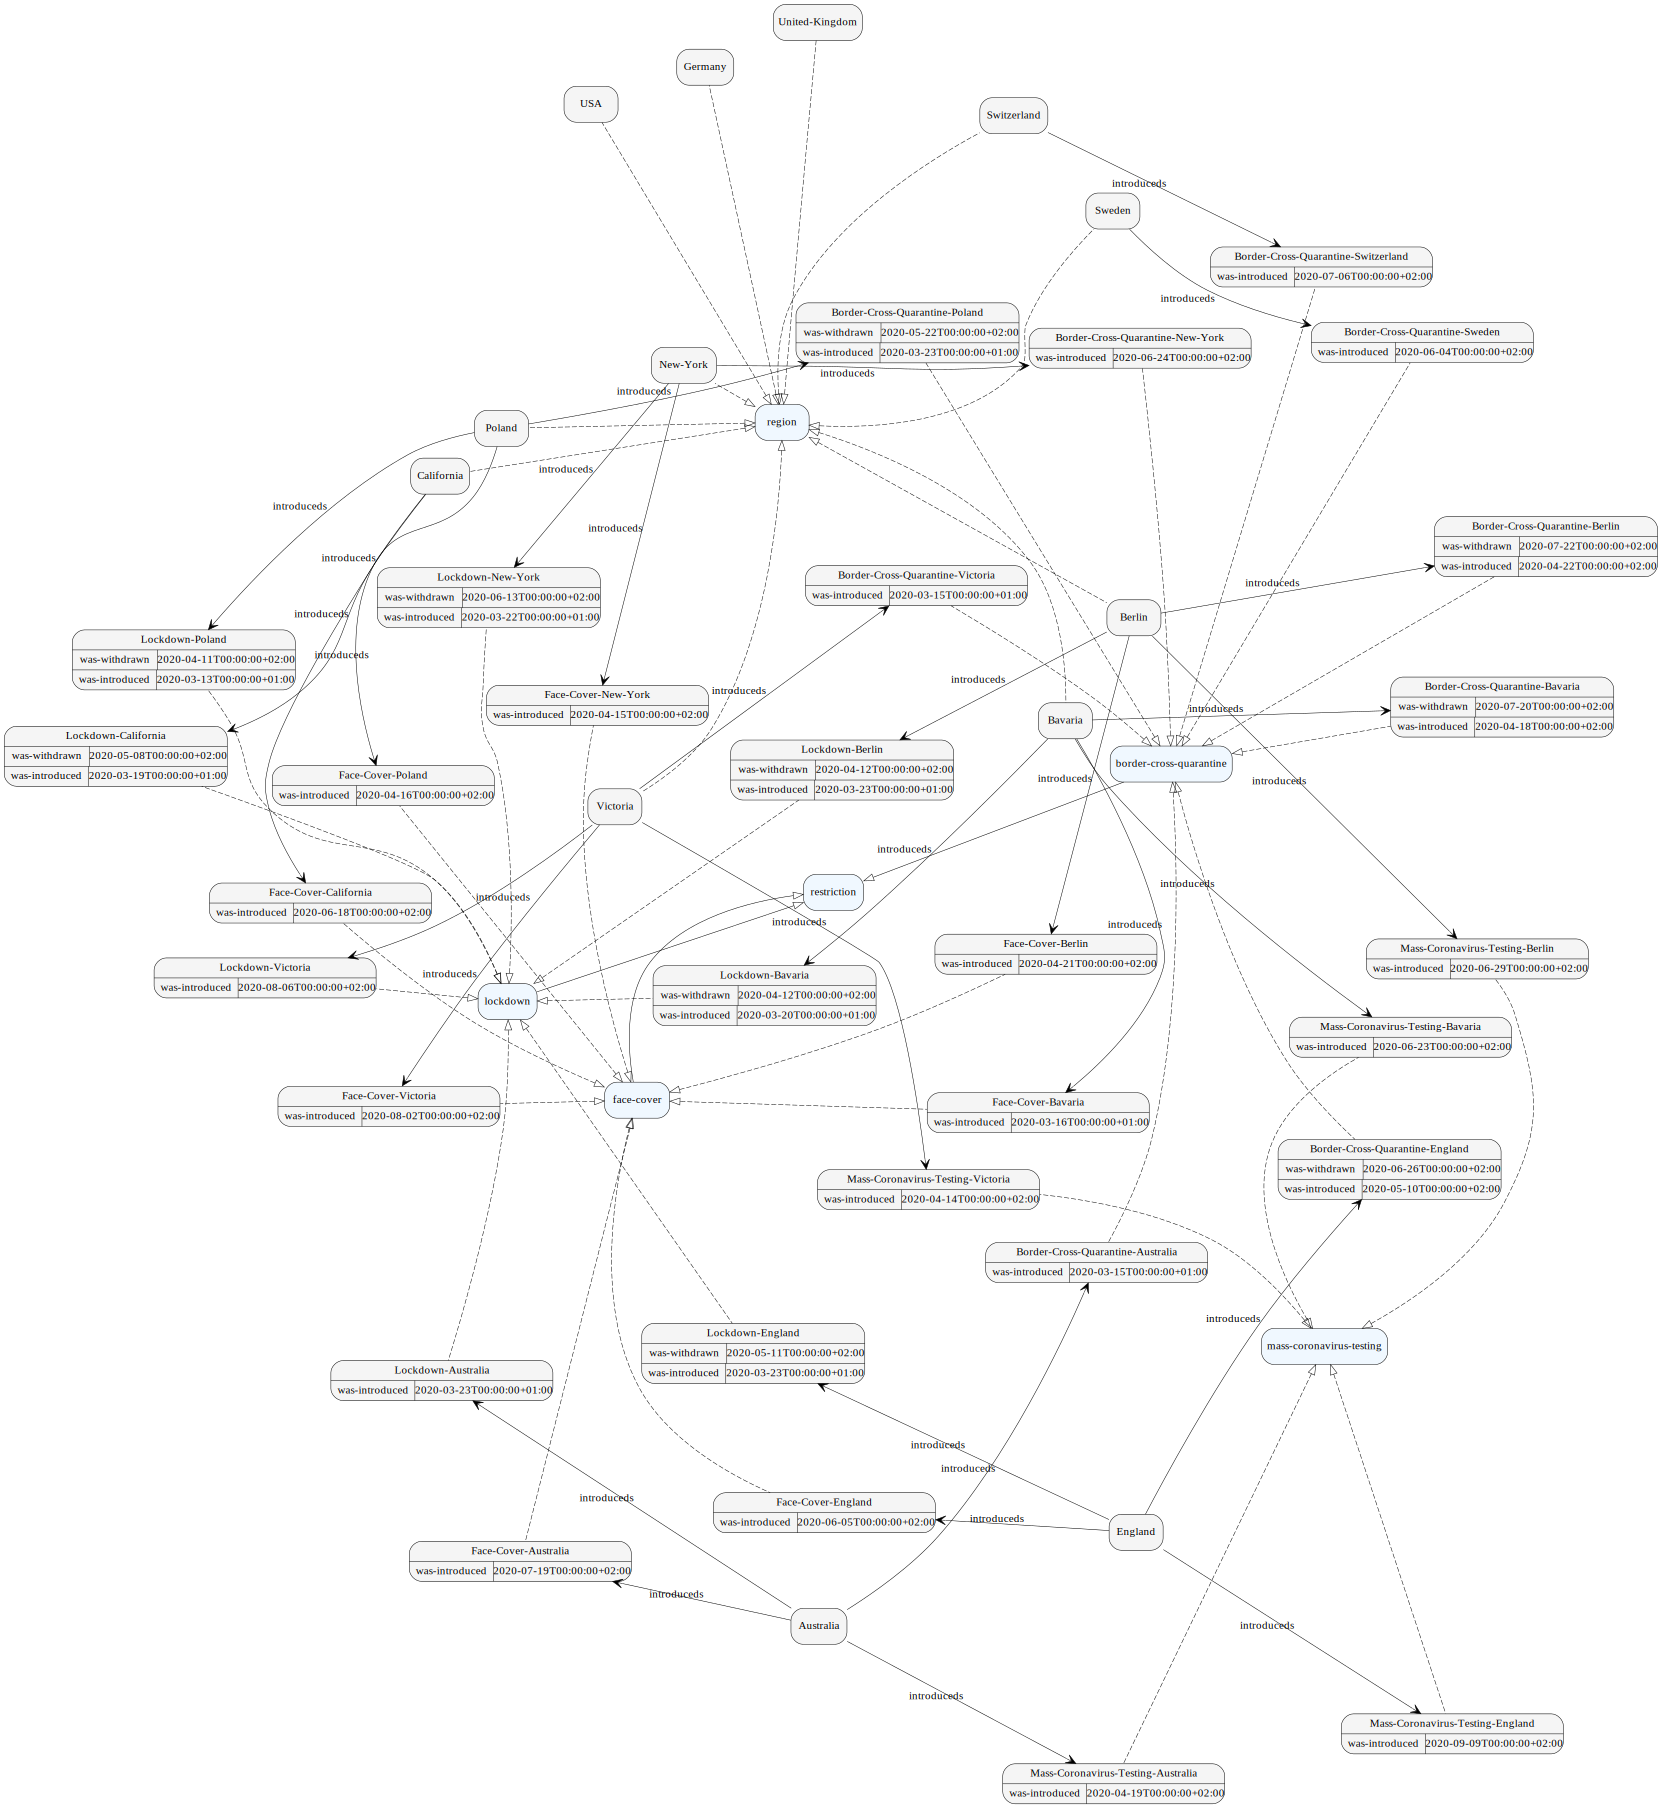

In [13]:
onto.draw_graph(layout='force directed')

You can select and print out all instaces of given concept's name.

In [5]:
onto.select_instances_of("region")

Instance                                        introduceds
0         Victoria  [Mass-Coronavirus-Testing-Victoria, Lockdown-V...
1           Berlin  [Mass-Coronavirus-Testing-Berlin, Lockdown-Ber...
2   United-Kingdom                                               None
3          Bavaria  [Mass-Coronavirus-Testing-Bavaria, Lockdown-Ba...
4         New-York  [Lockdown-New-York, Face-Cover-New-York, Borde...
5       California       [Lockdown-California, Face-Cover-California]
6           Sweden                     Border-Cross-Quarantine-Sweden
7           Poland  [Lockdown-Poland, Face-Cover-Poland, Border-Cr...
8          Germany                                               None
9              USA                                               None
10     Switzerland                Border-Cross-Quarantine-Switzerland

Cognipy allows you to do queries on ontology using sparql language. In example we query for every region which has indtroduced some restriction and then we save it to pandas dataframe. 

In [6]:
df=onto.sparql_query(CQL("""select ?Region ?Restriction ?Date{
                            ?Region rdf:type <region>. 
                            ?Restriction rdf:type <restriction>. 
                            ?Region <introduceds> ?Restriction. 
                            ?Restriction <was-introduced> ?Date.
                        }"""))

In [7]:
df['Date'] = pd.to_datetime(df['Date']).apply(lambda x: x.strftime('%Y-%d-%m'))
df = df.set_index("Region")
df

Restriction        Date
Region                                                      
Victoria                       Lockdown-Victoria  2020-06-08
Victoria                     Face-Cover-Victoria  2020-02-08
Victoria        Border-Cross-Quarantine-Victoria  2020-15-03
Berlin                           Lockdown-Berlin  2020-23-03
Berlin                         Face-Cover-Berlin  2020-21-04
Berlin            Border-Cross-Quarantine-Berlin  2020-22-04
Bavaria                         Lockdown-Bavaria  2020-20-03
Bavaria                       Face-Cover-Bavaria  2020-16-03
Bavaria          Border-Cross-Quarantine-Bavaria  2020-18-04
New-York                       Lockdown-New-York  2020-22-03
New-York                     Face-Cover-New-York  2020-15-04
New-York        Border-Cross-Quarantine-New-York  2020-24-06
California                   Lockdown-California  2020-19-03
California                 Face-Cover-California  2020-18-06
Sweden            Border-Cross-Quarantine-Sweden  2020-04-06
Poland                           Lockdown-Poland  2020-13-03
Poland                         Face-Cover-Poland  2020-16-04
Poland            Border-Cross-Quarantine-Poland  2020-23-03
Switzerland  Border-Cross-Quarantine-Switzerland  2020-06-07

Lets import covid cases data.

In [8]:
covid_data = pd.read_csv('data.csv', index_col=0)
covid_data.index = covid_data.index.str.replace(' ', '-')
covid_data = covid_data.T
covid_data.index = pd.to_datetime(covid_data.index)
covid_data = covid_data.T

covid_data.T.resample('M').mean().T.round()

2020-01-31  2020-02-29  2020-03-31  2020-04-30  2020-05-31  \
New-South-Wales         2.0         4.0       508.0      2819.0      3069.0   
Victoria                1.0         4.0       223.0      1261.0      1539.0   
Finland                 0.0         1.0       432.0      3316.0      6149.0   
Germany                 2.0        19.0     18974.0    131431.0    175091.0   
New-Zealand             0.0         0.0       117.0      1295.0      1498.0   
Norway                  0.0         1.0      1660.0      6677.0      8193.0   
Poland                  0.0         0.0       523.0      7841.0     18345.0   
Sweden                  0.0         2.0      1525.0     13045.0     30282.0   
Switzerland             0.0         1.0      5003.0     25595.0     30451.0   
US                      4.0        14.0     36077.0    656633.0   1465539.0   
United-Kingdom          0.0        21.0      9071.0    109999.0    225037.0   

                 2020-06-30  2020-07-31  2020-08-31  2020-09-30  2020-10-31  
New-South-Wales      3138.0      3544.0      3936.0      4173.0      4261.0  
Victoria             1810.0      5595.0     16418.0     19873.0     20250.0  
Finland              7080.0      7321.0      7754.0      8848.0     11188.0  
Germany            189025.0    202099.0    226604.0    267451.0    313448.0  
New-Zealand          1511.0      1548.0      1635.0      1804.0      1863.0  
Norway               8666.0      9027.0      9993.0     12457.0     14976.0  
Poland              29694.0     39470.0     56719.0     77145.0    110928.0  
Sweden              53702.0     73560.0     81264.0     87745.0     96581.0  
Switzerland         31187.0     33344.0     38328.0     47962.0     58274.0  
US                2162025.0   3584669.0   5363543.0   6640916.0   7563627.0  
United-Kingdom     272323.0    292647.0    318568.0    383040.0    544995.0

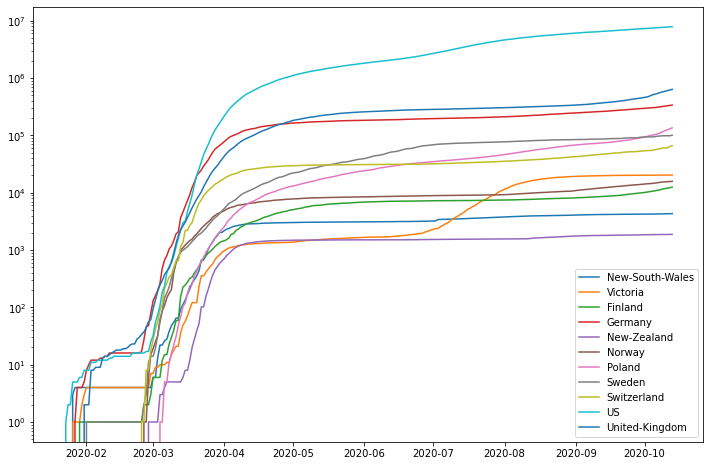

In [9]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))

for i, (name, row) in enumerate(covid_data.iterrows()):     
    plt.plot(covid_data.diff().columns.values, [x for x in row.values], label=covid_data.index[i])

plt.legend(loc=4)
plt.yscale("log")

plt.show()

Figure shows covid cases in time.

In another loop we edit data to show new cases daily...

In [10]:
for i, (name, row) in enumerate(covid_data.iterrows()):
    for x in range(len(row.values)-1, 0, -1):
        if row.values[x] > row.values[i-1]:
            row.values[x] = row.values[x] - row.values[x-1]
        else:
            row.values[x] = 0
                

... and then we plot it.

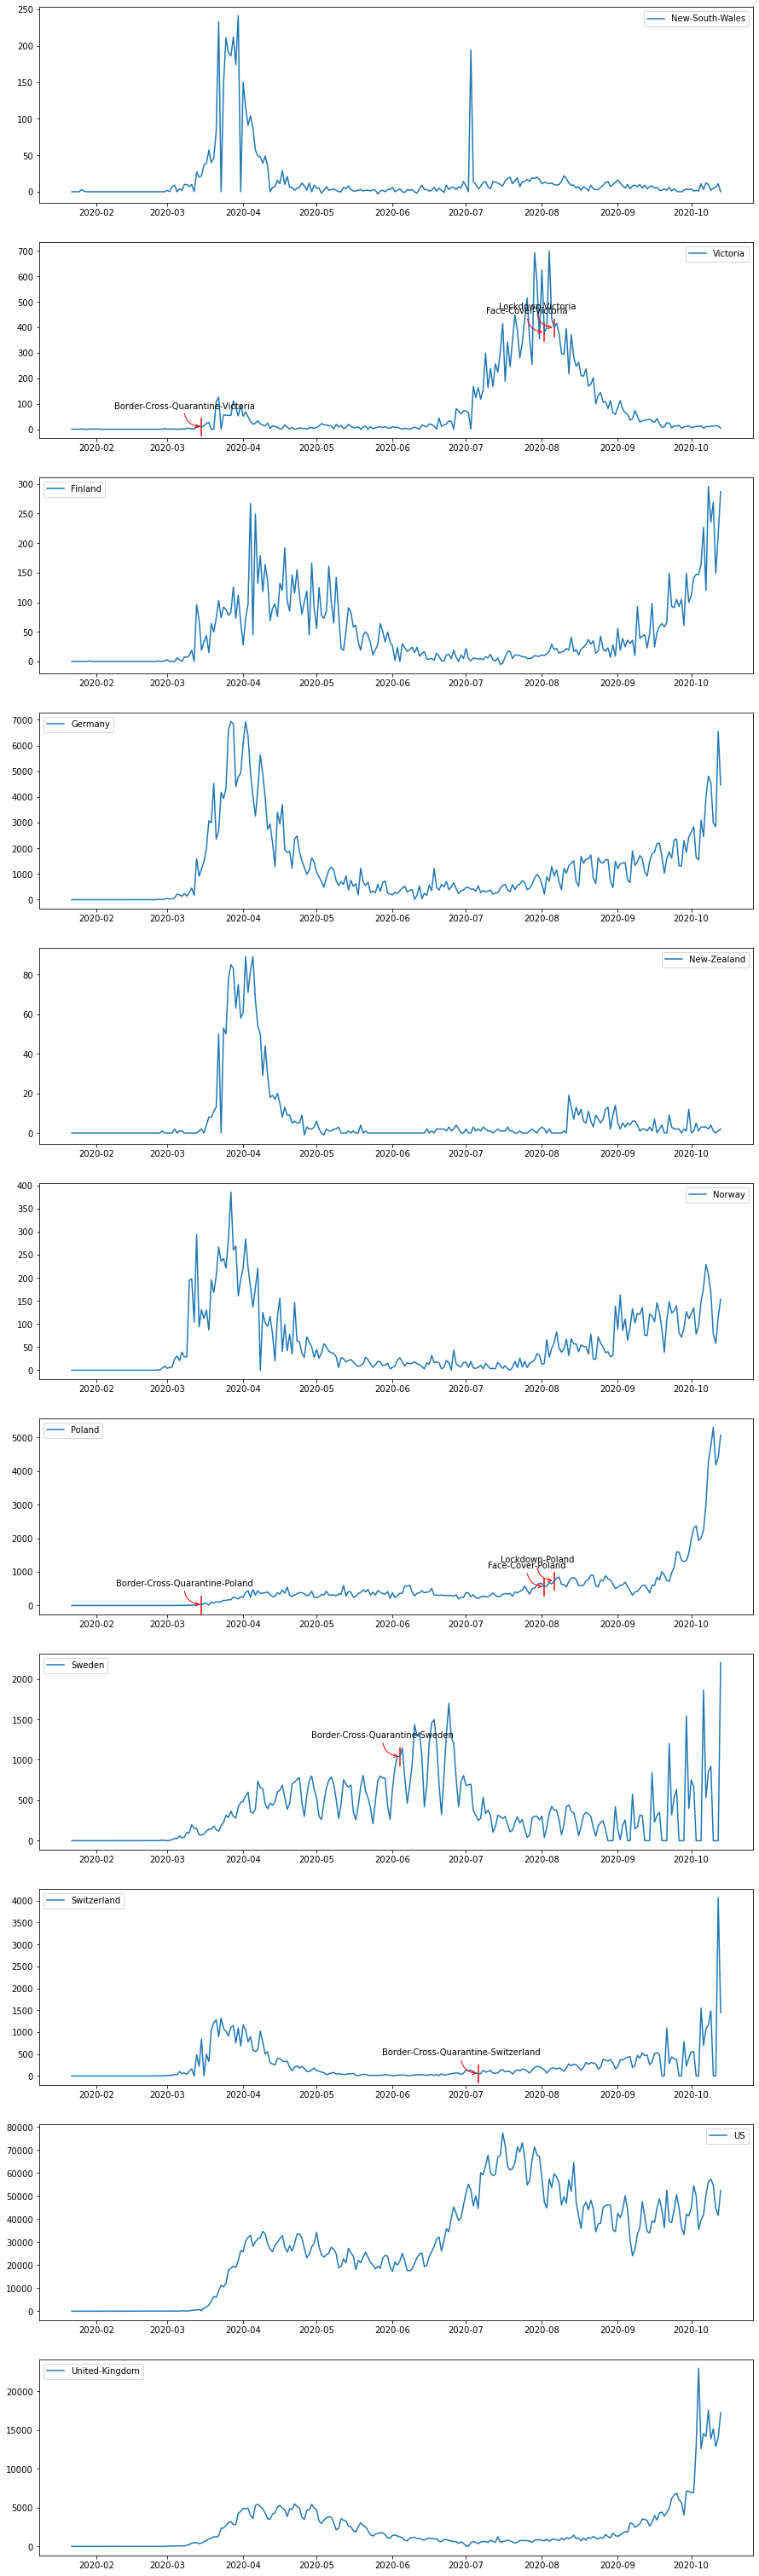

In [11]:
df.index = df.index.str.replace(' ', '-')
fig, axs = plt.subplots(11, figsize=(15,55))
for i, (name, row) in enumerate(covid_data.iterrows()):
    axs[i].plot(covid_data.diff().columns.values, [x for x in row.values], label=covid_data.index[i])
    axs[i].legend()
    try:
        if covid_data.index[i] in df.index:
            if len(df.loc[covid_data.index[i]]) > 2:
                for j, (name, row) in enumerate(df.loc[covid_data.index[i]].iterrows()):
                    date = datetime.datetime.strptime(df["Date"].values[j],'%Y-%d-%m') 
                    axs[i].scatter(date, covid_data.loc[row.name, date] , marker="|", s=500, c="red")
                    axs[i].annotate(row.Restriction, (date, covid_data.loc[row.name, date]), xytext=(-20,20), 
                        textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->',
                        connectionstyle='arc3,rad=0.5', color='red'))
            else:
                restriction, date = df.loc[covid_data.index[i]].values
                date = datetime.datetime.strptime(date,'%Y-%d-%m')
                axs[i].scatter(date, covid_data.loc[covid_data.index[i], date] , marker="|", s=500, c="red")
                axs[i].annotate(restriction, (date, covid_data.loc[covid_data.index[i], date]), xytext=(-20,20), 
                        textcoords='offset points', ha='center', va='bottom', arrowprops=dict(arrowstyle='->',
                        connectionstyle='arc3,rad=0.5', color='red'))
                
                
    except KeyError:
        continue

Plots contains marks on them which show when given restrcion was introduced.